[E5]-project_Spectrogram_Classification
===
 ---

<br/>


### 서론

Google Assistant, Siri, Bixby 등 우리들의 음성을 인식하는 비서들은 우리 생활에서 흔히 볼 수 있다. 이들이 어떤 방법으로 음성을 인식하고 분류하는지 여러가지 모델을 통해 살펴보자.

<br/>


![음성인식](https://user-images.githubusercontent.com/70703320/105654977-7e642e00-5f02-11eb-9a9e-8feb242ef3c4.jpg)
\[사진 출처: 미스터후스더보스 유튜브\]


<br/>


### 목표
- 오디오 데이터, 1차원 wave 형식 데이터를 STFT(Short Time Fourier Transform)을 통하여 2차원으로 변환하여 Spectrogram classification 모델을 구현해보자.
- Skip connection 모델을 추가하여 어떤 차이가 있는지 확인해보자.
- Conv1d layer가 아닌 Conv2d layer를 사용해보려는 시도도 해보자.

 

<br/>

### 데이터셋 정보 
- [캐글의 음성 인식 챌린지 데이터](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge) 

- [음성 파일에 대해 구체적으로 알고 싶다면 클릭](https://biology-statistics-programming.tistory.com/39?category=955669)

<br/>


### 목차
1. 데이터 준비
- 1-1. 데이터 경로 설정 후 불러오기 
- 1-2. 데이터셋 살펴보기
- 1-3. 데이터 확인해보기
    - 1) wav_vals데이터 수 만큼에서 하나를 랜덤으로 추출
    - 2) wav2spec 함수 정의
    - 3) 랜덤으로 추출된 하나의 데이터 모양 확인하기 (wav)
    - 4) 랜덤으로 추출된 하나의 데이터 모양 확인하기 (spec)
    - 5) label로 확인하고 소리로 들어보기
    - 6) 스펙트로그램 시각화
2. Train/Test 데이터셋 구성하기
- 2-1. 라벨 데이터 처리
    - 1) label_list(\['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'\])에 unknown과 silence 추가하기
    - 2) dictionary 형태로 전환
    - 3) label 데이터를 숫자로 변환하여 더 쉽게 사용
- 2-2. 1차원의 Waveform 데이터가 2차원의 Spectrogram 데이터로 변환
    - wav2spec을 통해 2차원으로 변환
- 2-3. 학습을 위한 데이터 분리
    - 1) Train : Test = 9 : 1의 비율로 분리하기
    - 2) train_spec, test_spec을 reshape해주기
    - 3) 나눠진 데이터셋 확인
    - 4) Hyper-parameter (batch_size와 max_epochs) 설정해주기
- 2-4. 데이터 세팅
    - 1) map 함수에 넘겨줄 데이터 전처리 함수
    - 2) tf.data.Datset함수
3. Conv1D layer를 이용해서 모델 구현
- 3-1. 모델 구성 (Conv1D layer)
- 3-2. loss 설정 - 12개의 Class 이므로 multi-class classification 
- 3-3. callback 함수로 학습 중간 원하는 동작을 하도록 설정할 수 있음
- 3-4. model fitting하기
- 3-5. 학습 결과 Plotting 하기
- 3-6. evaluation
- 3-7. test data를 평가하기 
    - 1) loss
    - 2) accuracy  
4. Skip-Connection model 구현
- 4-1. 모델 구성 (skip-connection)
- 4-2. loss 설정 - 12개의 Class 이므로 multi-class classification 
- 4-3. callback 함수로 학습 중간 원하는 동작을 하도록 설정할 수 있음
- 4-4. model fitting하기
- 4-5. 학습 결과 Plotting 하기
- 4-6. evaluation
- 4-7. test data를 평가하기 
    - 1) loss
    - 2) accuracy  
5. Conv2d layer model 구현
- 5-1. 모델 구성 (Conv2d layer model)
- 5-2. loss 설정 - 12개의 Class 이므로 multi-class classification 
- 5-3. callback 함수로 학습 중간 원하는 동작을 하도록 설정할 수 있음
- 5-4. model fitting하기
- 5-5. 학습 결과 Plotting 하기
- 5-6. evaluation
- 5-7. test data를 평가하기 
    - 1) loss
    - 2) accurac
6. 모델별 비교
7. 회고
8. 루브릭
---

## 1. 데이터 준비

### 1-1. 데이터 경로 설정 후 불러오기


In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

### 1-2. 데이터셋 살펴보기

In [2]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


- wave 데이터의 수는 50620개이고, 각각은 sampling rate가 8000이다.
- label 데이터의 수는 50620개이고, 각각은 1개의 라벨정보를 담고 있다.

### 1-3. 데이터 확인해보기

#### 1) wav_vals데이터 수 만큼에서 하나를 랜덤으로 추출

In [3]:
import IPython.display as ipd
import random

rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

rand num :  41194


#### 2) wav2spec 함수 정의

In [4]:
import librosa

def wav2spec(wav, fft_size=258): 
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

#### 3) 랜덤으로 추출된 하나의 데이터 모양 확인하기 (wav)

In [5]:
sr = 8000 
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)

Wave data shape :  (8000,)


1차원이므로 sampling rate: 8000만 나옴 

#### 4) label로 확인하고 소리로 들어보기 

In [6]:
print("label : ", speech_data["label_vals"][rand])
ipd.Audio(data, rate=sr)

label :  ['yes']


label로 나온 right과 음성으로 들리는 것이 일치한다!

#### 5) 랜덤으로 추출된 하나의 데이터 모양 확인하기 (spec)

In [7]:
spec = wav2spec(data)
print("Spectrogram shape : ",spec.shape)


Spectrogram shape :  (130, 126)


2차원으로 바꾸어주었으므로 시간:130과 주파수:126의 값이 같이 나옴 
#### 6) 스펙트로그램 시각화

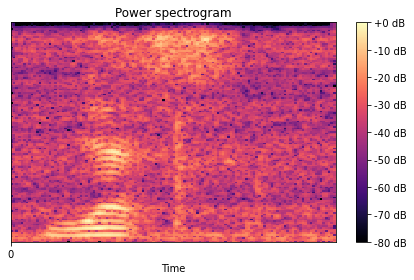

In [8]:
import matplotlib.pyplot as plt
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

"yes" 단어는 0.1~0.4초 구간에서 발음이 강하게 되는 것을 시각화하여 확인할 수 있다.

## 2. Train/Test 데이터셋 구성하기

### 2-1. 라벨 데이터 처리

#### 1) label_list(['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go'])에 unknown과 silence 추가하기

In [9]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']


#### 2) dictionary 형태로 전환

In [10]:
new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


#### 3) label 데이터를 숫자로 변환하여 더 쉽게 사용

In [11]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

print(label_data)

[ 3  3  3 ... 11 11 11]


### 2-2. 1차원의 Waveform 데이터가 2차원의 Spectrogram 데이터로 변환

#### wav2spec을 통해 2차원으로 변환

In [12]:
data_list = speech_data["wav_vals"]
spec_list = []

for data in data_list:
    spec_list.append(wav2spec(data))
spec_list = np.array(spec_list)

### 2-3. 학습을 위한 데이터 분리

#### 1) Train : Test = 9 : 1의 비율로 분리하기

In [13]:
from sklearn.model_selection import train_test_split

del speech_data
del data_list

spec_sr = 130
spec_sc = 126
train_spec, test_spec, train_label, test_label = train_test_split(spec_list, 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_spec)


[[[2.57632528e-02 5.96644841e-02 6.87206835e-02 ... 5.80068491e-02
   1.88217744e-01 3.25236917e-01]
  [3.35347205e-02 1.00893147e-01 1.73334494e-01 ... 2.39018217e-01
   2.54936188e-01 1.23973161e-01]
  [2.31091961e-01 2.56449997e-01 2.17007354e-01 ... 3.38972360e-01
   2.01792479e-01 6.73801079e-02]
  ...
  [5.84767386e-03 3.18284845e-03 7.24734389e-04 ... 6.88169326e-04
   4.92707454e-03 9.80987027e-03]
  [5.53267729e-03 2.62268726e-03 1.46452687e-04 ... 1.65697827e-04
   5.05970418e-03 9.56481975e-03]
  [5.43974806e-03 2.84914440e-03 8.47501215e-05 ... 1.50384309e-04
   4.76875668e-03 9.47002601e-03]]

 [[8.53014644e-03 8.40241206e-04 5.00597851e-03 ... 1.86165900e-03
   7.45619461e-03 1.61217041e-02]
  [1.30309789e-02 9.43823904e-03 2.58439034e-03 ... 4.56272112e-03
   9.70677659e-03 1.61192454e-02]
  [1.73188373e-02 9.29422304e-03 6.00598659e-03 ... 1.15769338e-02
   9.64801479e-03 1.14748785e-02]
  ...
  [4.47284011e-03 1.95078563e-03 5.66900824e-04 ... 5.74262405e-04
   2.43608

In [14]:
train_spec = train_spec.reshape(-1, spec_sr, spec_sc, 1) # add channel for CNN
test_spec = test_spec.reshape(-1, spec_sr, spec_sc, 1)

#### 2) 나눠진 데이터셋 확인

In [15]:
print("train data : ", train_spec.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_spec.shape)
print("test labels : ", test_label.shape)

train data :  (45558, 130, 126, 1)
train labels :  (45558,)
test data :  (5062, 130, 126, 1)
test labels :  (5062,)


#### 3) Hyper-parameter (batch_size와 max_epochs) 설정해주기

In [16]:
batch_size = 16
max_epochs = 8

checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj63/aiffel/speech_recognition/models/wav'

### 2-4. 데이터 세팅

#### 1) map 함수에 넘겨줄 데이터 전처리 함수

In [17]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

#### 2) tf.data.Datset함수

In [18]:
import tensorflow as tf

del spec_list

train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>


## 3. Conv1D layer를 이용해서 모델 구현

### 3-1. 모델 구성 (기본)

In [19]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(spec_sr, spec_sc)) 

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0     

### 3-2. loss 설정 - 12개의 Class 이므로 multi-class classification (Categorical Cross Entropy loss)

In [20]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

### 3-3. callback 함수로 학습 중간 원하는 동작을 하도록 설정할 수 있음

In [21]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

### 3-4. model fitting하기

In [22]:
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/8
2847/2847 [==============================] - ETA: 0s - loss: 1.3312 - accuracy: 0.5458
Epoch 00001: val_loss improved from inf to 0.75913, saving model to /home/aiffel-dj63/aiffel/speech_recognition/models/wav
2847/2847 [==============================] - 16s 6ms/step - loss: 1.3312 - accuracy: 0.5458 - val_loss: 0.7591 - val_accuracy: 0.7425
Epoch 2/8
2838/2847 [============================>.] - ETA: 0s - loss: 0.6525 - accuracy: 0.7867
Epoch 00002: val_loss improved from 0.75913 to 0.51796, saving model to /home/aiffel-dj63/aiffel/speech_recognition/models/wav
2847/2847 [==============================] - 15s 5ms/step - loss: 0.6518 - accuracy: 0.7868 - val_loss: 0.5180 - val_accuracy: 0.8252
Epoch 3/8
2841/2847 [============================>.] - ETA: 0s - loss: 0.4601 - accuracy: 0.8489
Epoch 00003: val_loss improved from 0.51796 to 0.41317, saving model to /home/aiffel-dj63/aiffel/speech_recognition/models/wav
2847/2847 [==============================] - 16s 6ms/step - loss

### 3-5. 학습 결과 Plotting 하기

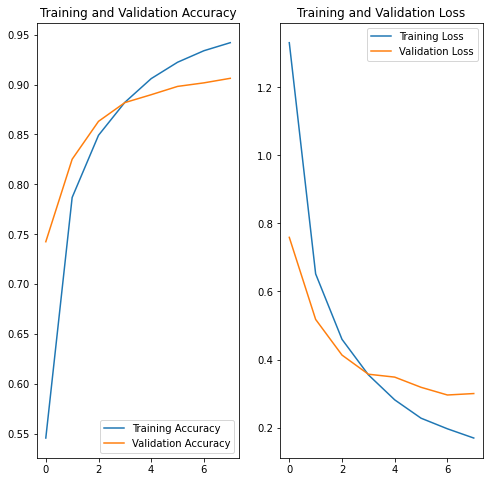

In [23]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

그래프를 보니 epoch를 8보다 더 늘리면 더 Training Loss와 Validation loss가 내려갈지 모르지만 과적합이 우려되어 적당하다고 판단하였음

### 3-6. evaluation

In [24]:
model_wav.load_weights(checkpoint_dir)

### 3-7. test data를 평가하기 

In [25]:
results = model_wav.evaluate(test_dataset)

317/317 [==============================] - 17s 55ms/step - loss: 0.2959 - accuracy: 0.9016


#### 1) loss

In [26]:
print("loss value: {:.3f}".format(results[0]))


loss value: 0.296


#### 2) accuracy

In [27]:
print("accuracy value: {:.4f}%".format(results[1]*100))

accuracy value: 90.1620%


## 4. Skip-Connection model 구현

### 4-1. 모델 구성

In [28]:
input_tensor = layers.Input(shape=(spec_sr, spec_sc))

del x
del output_tensor
del model_wav
del optimizer
del cp_callback
del history_wav
del acc
del val_acc
del loss
del val_loss
del epochs_range
del results

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 130, 32)      36320       input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 130, 32)      9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 65, 32)       0           conv1d_11[0][0]                  
____________________________________________________________________________________________

### 4-2. optimizer 설정 

In [29]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

### 4-3. check point 만들기

In [30]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

### 4-4. model fitting

In [31]:
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/8
2839/2847 [============================>.] - ETA: 0s - loss: 1.4439 - accuracy: 0.5088
Epoch 00001: val_loss improved from inf to 0.91102, saving model to /home/aiffel-dj63/aiffel/speech_recognition/models/wav_skip
2847/2847 [==============================] - 17s 6ms/step - loss: 1.4424 - accuracy: 0.5094 - val_loss: 0.9110 - val_accuracy: 0.6920
Epoch 2/8
2838/2847 [============================>.] - ETA: 0s - loss: 0.7219 - accuracy: 0.7616
Epoch 00002: val_loss improved from 0.91102 to 0.50110, saving model to /home/aiffel-dj63/aiffel/speech_recognition/models/wav_skip
2847/2847 [==============================] - 18s 6ms/step - loss: 0.7209 - accuracy: 0.7619 - val_loss: 0.5011 - val_accuracy: 0.8317
Epoch 3/8
2843/2847 [============================>.] - ETA: 0s - loss: 0.4782 - accuracy: 0.8429
Epoch 00003: val_loss improved from 0.50110 to 0.41046, saving model to /home/aiffel-dj63/aiffel/speech_recognition/models/wav_skip
2847/2847 [==============================] - 19s 

### 4-5. 시각화

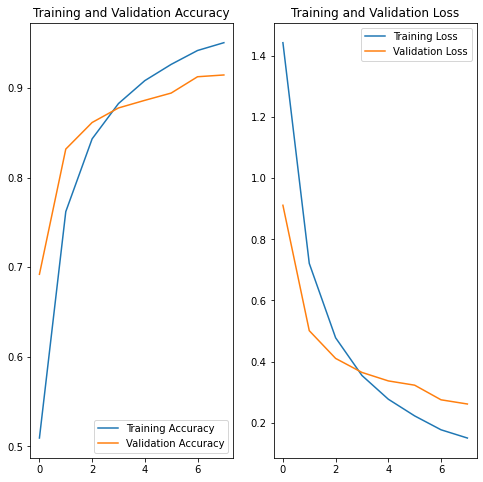

In [32]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 4-6.  Evaluation

In [33]:
model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

317/317 [==============================] - 5s 16ms/step - loss: 0.2614 - accuracy: 0.9143


#### 1) loss

In [34]:
print("loss value: {:.3f}".format(results[0]))

loss value: 0.261


#### 2) accuracy

In [35]:
print("accuracy value: {:.4f}%".format(results[1]*100))

accuracy value: 91.4263%


## 5. Conv2d layer model 구현
### 5-1. 모델 구성

In [36]:
input_tensor = layers.Input(shape=(spec_sr, spec_sc, 1)) 

del x
del output_tensor
del model_wav_skip
del optimizer
del cp_callback
del history_wav_skip
del acc
del val_acc
del loss
del val_loss
del epochs_range
del results

x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D(2,2)(x)

x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D(2,2)(x)

x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D(2,2)(x)

x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.MaxPool2D(2,2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_2D = tf.keras.Model(input_tensor, output_tensor)

model_wav_2D.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0   

### 5-2. optimizer 설정 

In [37]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_2D.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])

### 5-3. check point 만들기

In [38]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

### 5-4. model fitting

In [39]:
history_wav_2D = model_wav_2D.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/8
2845/2847 [============================>.] - ETA: 0s - loss: 0.7148 - accuracy: 0.7692
Epoch 00001: val_loss improved from inf to 0.30031, saving model to /home/aiffel-dj63/aiffel/speech_recognition/models/wav_skip
2847/2847 [==============================] - 69s 24ms/step - loss: 0.7144 - accuracy: 0.7693 - val_loss: 0.3003 - val_accuracy: 0.9037
Epoch 2/8
2846/2847 [============================>.] - ETA: 0s - loss: 0.2668 - accuracy: 0.9173
Epoch 00002: val_loss improved from 0.30031 to 0.18510, saving model to /home/aiffel-dj63/aiffel/speech_recognition/models/wav_skip
2847/2847 [==============================] - 73s 26ms/step - loss: 0.2668 - accuracy: 0.9173 - val_loss: 0.1851 - val_accuracy: 0.9420
Epoch 3/8
2846/2847 [============================>.] - ETA: 0s - loss: 0.1712 - accuracy: 0.9464
Epoch 00003: val_loss improved from 0.18510 to 0.15917, saving model to /home/aiffel-dj63/aiffel/speech_recognition/models/wav_skip
2847/2847 [==============================] - 67

### 5-5. 시각화

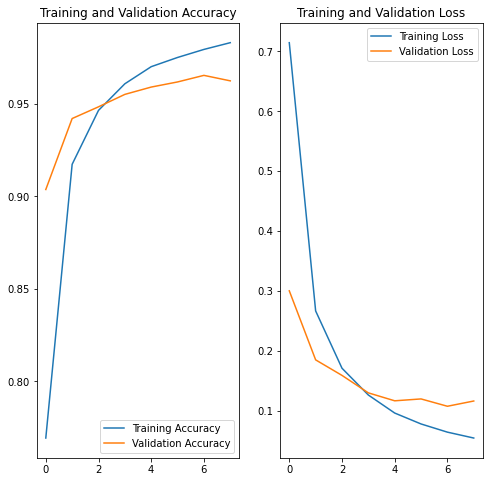

In [40]:
import matplotlib.pyplot as plt

acc = history_wav_2D.history['accuracy']
val_acc = history_wav_2D.history['val_accuracy']

loss=history_wav_2D.history['loss']
val_loss=history_wav_2D.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 5-6.  Evaluation

In [41]:
model_wav_2D.load_weights(checkpoint_dir)
results = model_wav_2D.evaluate(test_dataset)

317/317 [==============================] - 27s 84ms/step - loss: 0.1086 - accuracy: 0.9650


#### 1) loss

In [42]:
print("loss value: {:.3f}".format(results[0]))

loss value: 0.109


#### 2) accuracy

In [43]:
print("accuracy value: {:.4f}%".format(results[1]*100))

accuracy value: 96.5034%


## 6. 모델별 Accuracy 비교

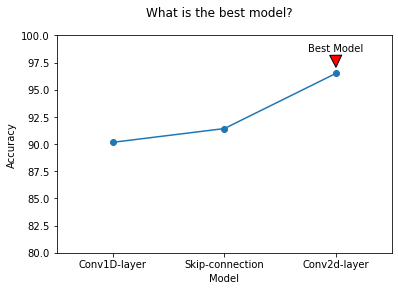

In [49]:
import matplotlib.pyplot as plt
model = ['Conv1D-layer', 'Skip-connection', 'Conv2d-layer']
accuracy = [90.1620, 91.4263, 96.5034]
plt.scatter(model, accuracy)
plt.plot(model, accuracy)
plt.axis([-0.5,2.5,80,100])
plt.suptitle('What is the best model?')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.annotate('Best Model', xy=(2, 97), xytext=(1.75, 98.5),
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.show()

## 7. 회고 

<br/>

#### 2차원으로 바꿔주는 것에 대한 문제
- 어느 지점에서 바꾸어야하나 하는 문제
    - 이것이 가장 난감했었다. 처음에는 이해를 잘하지 못하여 모델 구현 바로 전에 하였는데 2차원으로 바꿔준 후 데이터를 분리하고 reshape를 해야한다는 것을 깨달았다. 최종적으로 2차원으로 바꿔주는 시기는 데이터를 분리하고 reshape 하기 전인 2-2에 하기로 하였다.


- wav2spec은 데이터 하나에 대해서만 변환해주는 문제
    - wav2spec은 데이터 하나에 대해서만 변환해준다. 따라서, 내가 고안한 전략은 for문을 통해 speech_data\["wav_vals"\]에서 데이터 하나씩 불러와서 변환해준 후 최종적으로 그 리스트를 array형태로 바꿔주는 것이었다. 이 과정은 2-1 3)에서 볼 수 있다.
    
<br/>

#### 메모리 부족 현상에 대한 다양한 경우 (커널이 죽는 문제)
이 부분은 많은 사람들이 겪고 해결방안들을 제시해주어서 어렵지 않게 해결하였다. 하지만, 그 해결방안들을 한 번 정리해보았다.

- GPU가 아닌 CPU를 사용하고 있는 경우
    - 이 경우는 tensorflow를 GPU가 아닌 것으로 설치하였을 경우이다. 이와 같을 경우 CPU를 사용하고 있다는 오류가 떠 확인할 수 있으므로 이럴 경우 tensorflow를 지워준 후 tensorflow-gpu 를 설치하여 해결하면 된다.
    

- 다른 커널들을 사용하고 있는 경우
    - 이번 작업 같은 경우 메모리를 많이 사용하여야 하기 때문에 이 커널 이외의 것들을 전부 종료해준 후 따로 진행하는 것이 효율적이다. 
    

- del를 사용하여 앞서 저장한 리스트들을 비워주지 않는 경우
    - 이 경우가 문제 해결의 가장 핵심이라고 생각한다. 본인의 경우에는 2-1 3)에서 리스트(data_list)를 굳이 만들었기에 여기서 메모리를 많이 사용하였다. 따라서, 이를 지워주지 않아 메모리 부족 현상이 발생하였다. 이를 해결하기 위해 2-3 1) 에서 del speech_data, del data_list 등의 명령어를 통해 리스트에 담고 있던 정보를 사용해주며 메모리를 복구해주어 해결할 수 있었다. 또한, 4번 5번에서 새로운 모델을 설계할 때도 그 전에 있던 리스트들을 비워주었다.


<br/>

#### Conv2D 모델 설계에 있어서의 어려움

- input shape에 어떤 값의 형태로 넣어야하는가
    - 이전에 설계했었던 가위바위보 분류기 모델에서 Conv2D모델을 사용한 것을 생각하였고, 그때의 shape를 살펴보았다. 당시에 가로세로가 각각 32였고, 채널이 1이었다. 이번 것에 적용하기 위해서 shape를 시간, 주파수, 1로 해주었고 올바르게 작동하는 것을 볼 수 있었다.
  
  
- Conv2D 모델을 어떻게 설계할 것인가
    - CS231n 5강 내용을 마침 공부를 마친 터여서 필터의 크기와 stride , padding의 크기 설정 등을 한다는 것을 알 수 있었다. 이전에 가위바위보 분류기 모델에서 설정했던 값들을 그대로 사용하기로 하였다. 그 결과 올바르게 작동하는 것을 볼 수 있었다.

<br/>
<br/>

## 8. 루브릭

<br/>

#### 스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.
- 시각화: 1-3 6) 에서 확인 가능, 
![spec](https://user-images.githubusercontent.com/70703320/105841533-1b64bb00-6018-11eb-8bff-3d0cc7114ba3.png)
- train/test 데이터셋 구성: 2.3 1~2)에서 확인 가능
![train](https://user-images.githubusercontent.com/70703320/105841536-1c95e800-6018-11eb-9713-b701e60d15eb.png)

<br/>

#### 스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.
- 안정적으로 수렴: 5.6에서 확인 가능
![eval](https://user-images.githubusercontent.com/70703320/105841542-1e5fab80-6018-11eb-8b21-950fac0dba7a.png)
<br/>

#### evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.
- 6 에서 3가지 모델 모두 75% 이상임을 확인 가능
![best](https://user-images.githubusercontent.com/70703320/105841549-1f90d880-6018-11eb-8e1d-3e642c3658d5.png)